# 0. Overview

Angostura is hosted on Google's BigQuery.

This notebook will help you to instal the required dependencies and connect to Angostura's BigQuery database.

# 1. Install Dependencies

The only required dependency to communicate to BigQuery is the Google Cloud API.

In [1]:
import sys
!{sys.executable} -m pip install --upgrade pandas
!{sys.executable} -m pip install --upgrade google-cloud-bigquery[pandas]

Requirement already up-to-date: pandas in /home/federico/.local/lib/python3.7/site-packages (1.0.1)
Requirement already up-to-date: google-cloud-bigquery[pandas] in /home/federico/.local/lib/python3.7/site-packages (1.24.0)


# 2. Authentication Setup

Before being able to query the Angostura database you need to authenticate.
You will have read-only access to the tables.

In [2]:
# First we need to get the JSON key for authentication

import urllib.request

url = 'https://storage.googleapis.com/angostura-public/hult-hackathon-key.json'
urllib.request.urlretrieve(url, './hult-hackathon-key.json')

# Second, we add the key to our environment

import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = './hult-hackathon-key.json'

# 3. Import GCloud API

In [3]:
from google.cloud import bigquery

client = bigquery.Client()

# 4. Collect the data from BigQuery

In [4]:
# We can dump the BigQuery results directly into a DataFrame
QUERY = ('select * from `angostura_dev`.eh_health_survey_response')

df = client.query(QUERY).to_dataframe()

In [5]:
# Quick options to display more data in the output cells
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# 5. Calculate the completeness of the data

In [6]:
def empty_or_null(v):
    return v is None or (isinstance(v, str)  and v == '')

def empty_or_row(v):
    return v.map(empty_or_null).sum()


df['empty_count'] = df.apply(empty_or_row, axis=1)

df['total_count'] = 121

import datetime

def m_date(d):
    value = datetime.datetime.strptime(d, '%Y-%m-%dT%H:%M:%S.%fZ')
    c = value.isocalendar()
    return '{}-{}'.format(c[0], c[1])

df['survey_day'] = df['timestamp'].map(m_date)

week_sparsity = {}

for t in df['survey_day'].unique():
    empties = df[df['survey_day'] == t]['empty_count'].sum()
    totals = df[df['survey_day'] == t]['total_count'].sum()
    week_sparsity[t] = {'empties': empties, 'totals': totals, 'ratio': float(empties)/totals}
    
for k, v in week_sparsity.items():
    print('Week {}, blanks: {}'.format(k, v))

count = 0
s = 0

for v in week_sparsity.values():
    s += v['ratio']
    count += 1
    
print('\nAverage ratio: {}'.format(s/count))

Week 2019-34, blanks: {'empties': 644, 'totals': 3630, 'ratio': 0.17741046831955923}
Week 2019-29, blanks: {'empties': 610, 'totals': 3388, 'ratio': 0.18004722550177096}
Week 2019-36, blanks: {'empties': 473, 'totals': 2662, 'ratio': 0.17768595041322313}
Week 2019-27, blanks: {'empties': 324, 'totals': 1936, 'ratio': 0.16735537190082644}
Week 2020-5, blanks: {'empties': 583, 'totals': 4114, 'ratio': 0.14171122994652408}
Week 2019-46, blanks: {'empties': 834, 'totals': 4477, 'ratio': 0.18628545901273175}
Week 2019-50, blanks: {'empties': 446, 'totals': 2420, 'ratio': 0.18429752066115704}
Week 2019-24, blanks: {'empties': 364, 'totals': 1815, 'ratio': 0.20055096418732782}
Week 2020-3, blanks: {'empties': 635, 'totals': 3267, 'ratio': 0.19436792164064892}
Week 2019-40, blanks: {'empties': 529, 'totals': 3146, 'ratio': 0.16815003178639543}
Week 2019-48, blanks: {'empties': 714, 'totals': 4235, 'ratio': 0.16859504132231404}
Week 2019-43, blanks: {'empties': 820, 'totals': 4356, 'ratio': 0.1

# 6. Group the scarcity variables per group

Calculates the scarcity per row, considering the number of impacted days in a week.
Based on the group, measures the contribution of the variable to the group scarcity and summarize it.

With the three groups scarcity, consolidate the overall scarcity for the row, which can be averaged when grouped.

In [7]:
x_variables_9 = [ 'operability_icu',
                    'operability_icu_p',
                    'operability_er',
                    'operability_sx',
                    'operability_lab',
                    'operability_uls',
                    'operability_ct_mri',
                    'operability_xr']

x_variables_10 = [ 'er_avail_adrenalin',
                    'er_avail_atropine',
                    'er_avail_dopamine',
                    'er_avail_cephalosporins_betalactams',
                    'er_avail_aminoglycosides_quinolone',
                    'er_avail_vancomycin_clindamycin',
                    'er_avail_lidocaine',
                    'er_avail_minor_opioids',
                    'er_avail_major_opioids',
                    'er_avail_iv_fluids',
                    'er_avail_diazepam_dph',
                    'er_avail_heparin',
                    'er_avail_steroids',
                    'er_avail_insulin',
                    'er_avail_asthma',
                    'er_avail_blood_pressure',
                    'er_avail_defibrillator',
                    'er_avail_ott_intubation',
                    'er_avail_catheter',
                    'er_avail_oxygen_suction']

x_variables_11 = [  'sx_avail_minor_opioids',
                    'sx_avail_major_opioids',
                    'sx_avail_anesthetic_gases',
                    'sx_avail_anesthetics_iv',
                    'sx_avail_relaxants',
                    'sx_avail_ott_intubation',
                    'sx_avail_patient_lingerie_kit',
                    'sx_avail_disposables_mask_gloves_gown',
                    'sx_avail_oxygen_suction']

In [8]:
def map_9_10_11(v):
    if v == 'Nunca ha existido' or v== 'No existe':
        return 0
    elif v == 'No hubo' or v == 'No operativa':
        return 7/7
    elif v == 'Entre 1 y 2 días' or v == 'Menos de 3 de días':
        return 5/7
    elif v == 'Entre 3 y 5 días':
        return 3/7
    elif v == 'Todos los días':
        return 0/7
    else: #Todos los días
        return 0

d9 = {}
d10 = {}
d11 = {}

for v in x_variables_9:
    d9['scarcity_'+ v] = df[v].map(map_9_10_11) / len(x_variables_9)

d9 = pd.DataFrame(d9)
d9['scarcity_g9'] = d9.sum(axis=1)  
d9['scarcity_contrib_g9'] = (d9.sum(axis=1) - d9['scarcity_g9']) / 3

for v in x_variables_10:
    d10['scarcity_'+ v] = df[v].map(map_9_10_11) / len(x_variables_10)

d10 = pd.DataFrame(d10)
d10['scarcity_g10'] = d10.sum(axis=1)  
d10['scarcity_contrib_g10'] = (d10.sum(axis=1) - d10['scarcity_g10']) / 3

for v in x_variables_11:
    d11['scarcity_'+ v] = df[v].map(map_9_10_11) / len(x_variables_11)

d11 = pd.DataFrame(d11)
d11['scarcity_g11'] = d11.sum(axis=1)  
d11['scarcity_contrib_g11'] = (d11.sum(axis=1) - d11['scarcity_g11']) / 3

new_df = pd.concat([d9, d10, d11], axis=1, sort=False)

new_df['total_scarcity'] = new_df['scarcity_contrib_g11'] + new_df['scarcity_contrib_g10'] + new_df['scarcity_contrib_g9']

df = pd.concat([df, new_df], axis=1, sort=False)

df['total_scarcity']

0       0.559127
1       0.573148
2       0.563624
3       0.566005
4       0.649735
          ...   
1007    0.348016
1008    0.342196
1009    0.387434
1010    0.200000
1011    0.656481
Name: total_scarcity, Length: 1012, dtype: float64

`total_scarcity` the lower the better, as it means the things are operativa for more days.

# 7. Create model with extra information

We will use the `total_scarcity` with `federal_entity`, `hospital_type` and 
`administrative_entity` to see if there is a correlation and build a new model from it.

In [9]:
d = {'real_score': new_df['total_scarcity']}

dependant_variables = ['federal_entity',
                       'hospital_type',
                       'administrative_entity',
                       ]

for v in dependant_variables:
    d[v] = df[v]

loc_df = pd.DataFrame(d)

We will transform this categorical variables into numbers:

- `federal_entity` into a value [0,1], meaning how rural it is (bigger the more rural)
- `hospital_type` into a value [0,1], meaning how dense is the population based on the type of hospital (IV is for more dense areas)
- `administrative_entity` into a value [0,1], meaning how dependent it is from the goverment

In [10]:
ENTITY_MAP = {
    'Amazonas': 1, 
    'Anzoátegui': 0.25, 
    'Apure': 1, 
    'Aragua': 0.25, 
    'Bolívar': 0.5, 
    'Carabobo': 0.25,
    'Dtto Capital': 0, 
    'Miranda': 0.25, 
    'Falcón': 0.5, 
    'Delta Amacuro': 1, 
    'Portuguesa': 0.75,
    'Zulia': 0.25, 
    'Barinas': 1, 
    'Guárico': 1, 
    'Nueva Esparta': 1, 
    'Mérida': 0.25, 
    'Sucre': 0.25,
    'Táchira': 0.25, 
    'Vargas': 0.25, 
    'Lara': 0.25, 
    'Monagas': 0.5
}
    
ENTITY_INVERSE_MAP = {}

for k, v in ENTITY_MAP.items():
    ENTITY_INVERSE_MAP[v] = k
    
def map_entity(m, v):
    return m.get(v)

HOSPITAL_MAP = {
    'Tipo II': 0, 
    'Tipo IV': 1, 
    'Tipo III': 0.5
}
    
HOSPITAL_INVERSE_MAP = {}

for k, v in HOSPITAL_MAP.items():
    HOSPITAL_INVERSE_MAP[v] = k

ADMINISTRATIVE_MAP = {
    'MPPS': 1,
    'MPPS, INSALUD APURE': 1, 
    'MPPS, INSALUD': 1, 
    'Sanidad Militar': 1,
    'IVSS': 0.75, 
    'ISP BOLIVAR': 1, 
    'ISP Estado Bolivar': 1, 
    'ISP BOLÍVAR ': 1, 
    'Isp': 1,
    'ISP Bolívar ': 1, 
    'ISP ': 1, 
    'ISP': 1, 
    'IVSS, MPPS': 0.75, 
    'Gob. Estatal': 1,
    'Instituto Autonomo': 0.5, 
    'INSTITUTO AUTÓNOMO': 0.5, 
    'Instituto Autónomo': 0.5,
    'Instituto autónomo': 0.5, 
    'INSTITUTO AUTONOMO': 0.5,
    'MPPS, instituto autonomo': 0.5, 
    'MPPS, Instituto autonomo': 0.5,
    'instituto autonomo': 0.5, 
    'Instituto AUtonomo': 0.5,
    'Sanidad Militar, Instituto autonomo': 0.5,
    'Sanidad Militar, SERVICIO AUTONOMO': 0.5, 
    'MPPS,  Autonomo': 0.5,
    'MPPS,  INSTITUTO AUTONOMO': 0.5, 
    'instituto  autónomo': 0.5,
    'Instituto Autonomo ': 0.5, 
    'MPPS, Gob. Estatal': 1,
    'MPPS, Gob. Estatal, Corposalud aragua': 1,
    'MPPS, Sanidad Militar, Gob. Estatal, Barrio Adentro': 1,
    'MPPS, Gob. Estatal, Barrio Adentro': 1,
    'MPPS, Gob. Estatal, Servicio autonomo': 0.5,
    'MPPS, Gob. Estatal, Servicio autónomo ': 0.5, 
    'MPPS, Barrio Adentro': 1
}
    
ADMINISTRATIVE_INVERSE_MAP = {}

for k, v in ADMINISTRATIVE_MAP.items():
    ADMINISTRATIVE_INVERSE_MAP[v] = k

loc_df['rural'] = loc_df['federal_entity'].map(lambda v: map_entity(ENTITY_MAP, v))
loc_df['population_density'] = loc_df['hospital_type'].map(lambda v: map_entity(HOSPITAL_MAP, v))
loc_df['goverment'] = loc_df['administrative_entity'].map(lambda v: map_entity(ADMINISTRATIVE_MAP, v))

In [11]:
loc_df['hospital_type'].value_counts()

Tipo IV     695
Tipo III    264
Tipo II      53
Name: hospital_type, dtype: int64

In [12]:
loc_df['federal_entity'].value_counts()

Dtto Capital     258
Bolívar           68
Táchira           62
Carabobo          56
Falcón            45
Nueva Esparta     45
Aragua            44
Delta Amacuro     39
Barinas           38
Guárico           38
Sucre             38
Anzoátegui        37
Vargas            37
Amazonas          37
Portuguesa        35
Monagas           33
Apure             28
Zulia             23
Mérida            22
Miranda           17
Lara              12
Name: federal_entity, dtype: int64

/home/federico/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


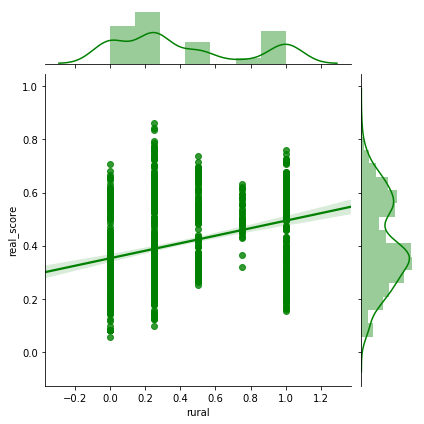

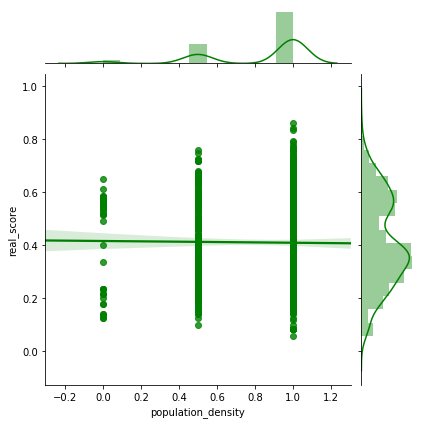

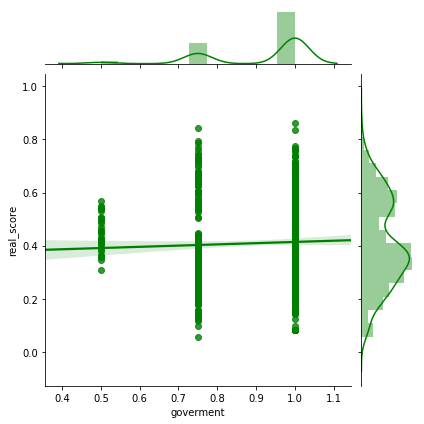

In [13]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from sklearn import linear_model

%matplotlib inline

import seaborn as sns # enhanced data visualization

for v in ['rural', 'population_density', 'goverment']:
    sns.jointplot(x = loc_df[v],
                  y = loc_df['real_score'],
                  kind="reg",  
                  color = 'g')
    plt.xlabel(v)

`rural` is the only variable that looks to have influence over the `scarcity`.

Lets create a model taking into account `rural` and `population_density`:

In [14]:
model = smf.ols(formula='real_score ~ rural + population_density', data=loc_df)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             real_score   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     85.70
Date:                Sun, 16 Feb 2020   Prob (F-statistic):           4.21e-35
Time:                        16:41:16   Log-Likelihood:                 467.03
No. Observations:                1012   AIC:                            -928.1
Df Residuals:                    1009   BIC:                            -913.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.1988      0

The model looks good, lets see how it can predict and a graph of it:

rural=0 and density=0 predicts [[0.19881595]]
rural=0 and density=1 predicts [[0.35138055]]
rural=1 and density=0 predicts [[0.41167379]]
rural=1 and density=1 predicts [[0.56423838]]


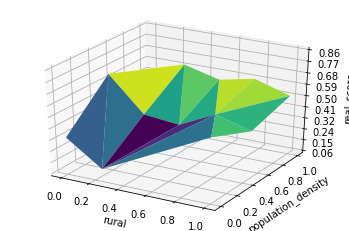

In [15]:
X = loc_df[['rural', 'population_density']]
y = pd.DataFrame(loc_df, columns=["real_score"])

from sklearn import linear_model

lm = linear_model.LinearRegression()
new_model = lm.fit(X,y)

for r, d in [(0, 0), (0, 1), (1, 0), (1, 1)]:
    prediction = lm.predict(pd.DataFrame({'rural': pd.Series(np.array([r])), 'population_density': pd.Series(np.array([d]))}))
    print('rural={} and density={} predicts {}'.format(r, d, prediction))
    
X = loc_df['rural']
Y = loc_df['population_density']
Z = loc_df['real_score']

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(X, Y, Z, cmap=plt.cm.viridis, linewidth=0.2)
ax.set_xlabel('rural')
ax.set_ylabel('population_density')
ax.set_zlabel('real_score')
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
plt.show()

Clearly shows that a non rural area with big density is the less scarse place (it is predicting `total_scarcity`, which lower the better)

# 8. Categorical variables

Prepare the variables by translating text strings to numeric values to run the correlation.

In [16]:
def categorical_variable(value):
    if value == 'Nunca ha existido':
        return 0
    elif value == 'No hay' or value == 'No operativa':
        return 1
    elif value == 'Menos de 3 días' :
        return 2
    elif value == 'Entre 3 y 5 días':
        return 3
    elif value == 'Todos los días': 
        return 4
    else:
        return ""
    
categorical_variables = ['op_pavilions_count',
                        'operability_icu',
                        'operability_icu_p',
                        'operability_er',
                        'operability_sx',
                        'operability_lab',
                        'operability_uls',
                        'operability_ct_mri',
                        'operability_xr',
                        'er_avail_adrenalin',
                        'er_avail_atropine',
                        'er_avail_dopamine',
                        'er_avail_cephalosporins_betalactams',
                        'er_avail_aminoglycosides_quinolone',
                        'er_avail_vancomycin_clindamycin',
                        'er_avail_lidocaine',
                        'er_avail_minor_opioids',
                        'er_avail_major_opioids',
                        'er_avail_iv_fluids',
                        'er_avail_diazepam_dph',
                        'er_avail_heparin',
                        'er_avail_steroids',
                        'er_avail_insulin',
                        'er_avail_asthma',
                        'er_avail_blood_pressure',
                        'er_avail_defibrillator',
                        'er_avail_ott_intubation',
                        'er_avail_catheter',
                        'er_avail_oxygen_suction',
                        'sx_avail_minor_opioids',
                        'sx_avail_major_opioids',
                        'sx_avail_anesthetic_gases',
                        'sx_avail_anesthetics_iv',
                        'sx_avail_relaxants',
                        'sx_avail_ott_intubation',
                        'sx_avail_patient_lingerie_kit',
                        'sx_avail_disposables_mask_gloves_gown',
                        'sx_avail_oxygen_suction',
                        'rrt_hemodialysis_avail_filter',
                        'rrt_hemodialysis_avail_lines',
                        'rrt_hemodialysis_avail_kit_hemodialysis',
                        'rrt_hemodialysis_avail_iron',
                        'rrt_hemodialysis_avail_b_complex',
                        'rrt_hemodialysis_avail_calcium',
                        'rrt_hemodialysis_avail_zemblar',
                        'rrt_reverse_osmosis_unit_operability',
                        'rrt_staff_nephrology',
                        'rrt_staff_md',
                        'rrt_staff_resident',
                        'rrt_staff_nurse',
                        'rrt_staff_nurse_nephrologist']

d = {}

for v in categorical_variables:
    d['cat_'+v] = df[v].map(categorical_variable)

df = pd.concat([df, pd.DataFrame(d)], axis=1, sort=False)


In [17]:
def categorical_variable1(value):
    if value == 'Mas de 1 año':
        return 0
    elif value == 'Entre 6 meses y 1 Año':
        return 1
    elif value == 'Entre 3 y 6 meses' :
        return 2
    elif value == 'Entre uno y 3 meses':
        return 3
    elif value == 'Entre una semana y 1 mes':
        return 4
    elif value == 'Menos de una semana':
        return 5
    else: #Empty values
        return ""
      
categorical_variables1 = ['rrt_date_stopped_operability','nutr_date_stopped_operability']

for v in categorical_variables1:
    df['cat_'+v] = df[v].map(categorical_variable1)

In [18]:
def categorical_variable2(value):
    if value == 'Ningún día':
        return 0
    elif value == 'Entre 1 y 2 días':
        return 1
    elif value == 'Entre 3 y 5 días' :
        return 2
    elif value == 'Todos los días':
        return 3
    else: #Empty values
        return ""
        
categorical_variables2 = ['nutr_num']

for v in categorical_variables2:
    df['cat_'+v] = df[v].map(categorical_variable2)


In [19]:
def categorical_variable3(value):
    if value == 'Ningún día':
        return 0
    elif value == 'Entre 1 y 2 días':
        return 1
    elif value == 'Entre 3 y 5 días' :
        return 2
    elif value == 'Todos los días':
        return 3
    else: #Empty values
        return ""
    
categorical_variables3 = ['power_outage_days_count']

for v in categorical_variables3:
    df['cat_'+v] = df[v].map(categorical_variable3)


In [20]:
placeholder_lst = []
# looping over each email address
for index, col in df.iterrows():
    mhfcc = []
    if 'Equipos' in df.loc[index, 'mortality_hospital_failure_cardiovascular_cause']:
        mhfcc.append(1)
    else:
        mhfcc.append(0)
        
    if 'Medicamentos' in df.loc[index, 'mortality_hospital_failure_cardiovascular_cause']:
        mhfcc.append(1)
    else:
        mhfcc.append(0)        
        
    if 'Recurso Humano' in df.loc[index, 'mortality_hospital_failure_cardiovascular_cause']:
        mhfcc.append(1)
    else:
        mhfcc.append(0)                
        
    if 'Luz eléctrica' in df.loc[index, 'mortality_hospital_failure_cardiovascular_cause']:
        mhfcc.append(1)
    else:
        mhfcc.append(0)                        
        
    if 'Resto estructurales' in df.loc[index, 'mortality_hospital_failure_cardiovascular_cause']:
        mhfcc.append(1)
    else:
        mhfcc.append(0)                                
    
    placeholder_lst.append(mhfcc) 
    
mhfcc_categ = pd.DataFrame(placeholder_lst)
mhfcc_categ.columns = ['mhfcc_eq' , 'mhfcc_me', 'mhfcc_rh',
                     'mhfcc_le', 'mhfcc_re']

df = pd.concat([df, mhfcc_categ], axis=1, sort=False)

In [21]:
placeholder_lst = []
# looping over each email address
for index, col in df.iterrows():
    mhftc = []
    if 'Equipos' in df.loc[index, 'mortality_hospital_failure_trauma_cause']:
        mhftc.append(1)
    else:
        mhftc.append(0)
        
    if 'Medicamentos' in df.loc[index, 'mortality_hospital_failure_trauma_cause']:
        mhftc.append(1)
    else:
        mhftc.append(0)        
        
    if 'Recurso Humano' in df.loc[index, 'mortality_hospital_failure_trauma_cause']:
        mhftc.append(1)
    else:
        mhftc.append(0)                
        
    if 'Luz eléctrica' in df.loc[index, 'mortality_hospital_failure_trauma_cause']:
        mhftc.append(1)
    else:
        mhftc.append(0)                        
        
    if 'Resto estructurales' in df.loc[index, 'mortality_hospital_failure_trauma_cause']:
        mhftc.append(1)
    else:
        mhftc.append(0)                                
    
    placeholder_lst.append(mhftc) 
    
mhftc_categ = pd.DataFrame(placeholder_lst)
mhftc_categ.columns = ['mhftc_eq' , 'mhftc_me', 'mhftc_rh',
                     'mhftc_le', 'mhftc_re']

df = pd.concat([df, mhftc_categ], axis=1, sort=False)

In [22]:
def binomial(value):
    if value == 'No'or value == 'menos de 3 comidas' or value == 'sin especialista':
        return 0
    elif value == 'Si'or value == '3 comidas' or value == 'con especilaista':
        return 1
    else: #Empty values
        return ""
    
binomial_list = ['rrt_avail',
                 'rrt_operability',
                 'nutr_avail',
                 'nutr_operability',
                 'nutr_daily_freq_meal',
                 'nutr_quality',
                 'power_outage',
                 'power_outage_equipment_failure',
                 'power_generator_available',
                 'power_outage_mortatility',
                 'nCoV_face_mask_avail',
                 'nCoV_respiratory_isolation_protocol_avail',
                 'nCoV_isolation_area_avail']

for v in binomial_list:
    df['bin_'+v] = df[v].map(binomial)


In [23]:
def map_hour(v):
    return int(v[11:13])

def map_minute(v):
    return int(v[14:16])

new_df['poad_hour'] = df['power_outage_avg_duration'].map(map_hour)
new_df['poad_minutes'] = df['power_outage_avg_duration'].map(map_minute)
    
# placeholder list
placeholder_lst = []

# looping over each 
for index, col in df.iterrows():
    week_year = df.loc[index, 'report_week'].split(sep = ' ')
    placeholder_lst.append(week_year) 
    
w_y_split = pd.DataFrame(placeholder_lst)
w_y_split.columns = ['week' , 'none', 'year']

df['report_week_number'] = w_y_split['week']
df['report_year_number'] = w_y_split['year']


In [24]:
#UDF for creating multiple DUMMIES
def dummy_multiple (var_name, col_name,n):
#new column per combination
  
    df['dumm_'+col_name+n] = 0
    condition = df.loc[0:,'dumm_'+col_name+n][df[col_name] == var_name]
    df['dumm_'+col_name+n].replace(to_replace = condition,
                                    value      = 1,
                                    inplace    = True)

In [25]:
#Categorical Variable 5 DUMMIES
dummy_multiple("Protestas  sin suspensión de actividades","strike_medical_staff_affected",'1')
dummy_multiple("Protestas con suspensión temporal  de actividades","strike_medical_staff_affected",'2')
dummy_multiple("""Huelga (suspendidas todas las actividades)""","strike_medical_staff_affected",'3')

dummy_multiple("Protestas  sin suspensión de actividades",'strike_nurses_affected','1')
dummy_multiple("Protestas con suspensión temporal  de actividades",'strike_nurses_affected','2')
dummy_multiple("""Huelga (suspendidas todas las actividades)""",'strike_nurses_affected','3')

dummy_multiple("Protestas  sin suspensión de actividades",'strike_other_staff_affected','1')
dummy_multiple("Protestas con suspensión temporal  de actividades",'strike_other_staff_affected','2')
dummy_multiple("""Huelga (suspendidas todas las actividades)""",'strike_other_staff_affected','3')

dummy_multiple("Protestas  sin suspensión de actividades",'strike_patients_affected','1')
dummy_multiple("Protestas con suspensión temporal  de actividades",'strike_patients_affected','2')
dummy_multiple("""Huelga (suspendidas todas las actividades)""",'strike_patients_affected','3')

dummy_multiple("Protestas  sin suspensión de actividades",'strike_other_affected','1')
dummy_multiple("Protestas con suspensión temporal  de actividades",'strike_other_affected','2')
dummy_multiple("""Huelga (suspendidas todas las actividades)""",'strike_other_affected','3')

In [26]:
#Water service
dummy_multiple("Hubo fórmulas lácteas entre 3 y 5 días",'nutr_freq_milk_formulas','1')

In [27]:
dummy_multiple("< 3 días, con soporte alterno",'wash_failure_icu','1')
dummy_multiple("""< 3 días, sin soporte alterno (cisternas)""",'wash_failure_icu','2')
dummy_multiple("3 a 5 días , sin soporte alterno",'wash_failure_icu','3')
dummy_multiple("3 a 5 días, con soporte alterno",'wash_failure_icu','4')
dummy_multiple("Hubo agua todos los días",'wash_failure_icu','5')
dummy_multiple("No hubo agua ningún dia",'wash_failure_icu','6')

dummy_multiple("< 3 días, con soporte alterno",'wash_failure_er','1')
dummy_multiple("""< 3 días, sin soporte alterno (cisternas)""",'wash_failure_er','2')
dummy_multiple("3 a 5 días , sin soporte alterno",'wash_failure_er','3')
dummy_multiple("3 a 5 días, con soporte alterno",'wash_failure_er','4')
dummy_multiple("Hubo agua todos los días",'wash_failure_er','5')
dummy_multiple("No hubo agua ningún dia",'wash_failure_er','6')
               
dummy_multiple("< 3 días, con soporte alterno",'wahs_failure_sx','1')
dummy_multiple("""< 3 días, sin soporte alterno (cisternas)""",'wahs_failure_sx','2')
dummy_multiple("3 a 5 días , sin soporte alterno",'wahs_failure_sx','3')
dummy_multiple("3 a 5 días, con soporte alterno",'wahs_failure_sx','4')
dummy_multiple("Hubo agua todos los días",'wahs_failure_sx','5')
dummy_multiple("No hubo agua ningún dia",'wahs_failure_sx','6')

In [28]:
df.to_excel("Tableau_input.xlsx")

In [29]:
#Correlation matrix
# creating a (Spearman) correlation matrix
corr_df = df.corr(method="spearman").round(2)


# printing (Spearman) correlations with SalePrice
print(corr_df.loc[:,'mortality_hospital_failure_cardiovascular_count'].sort_values(ascending = False))

print(corr_df.loc[:,'mortality_hospital_failure_trauma_count'].sort_values(ascending = False))

corr_df.to_excel('SpCorrelMatrix.xlsx')

mortality_hospital_failure_cardiovascular_count    1.00
mhfcc_me                                           0.84
mortality_hospital_failure_trauma_count            0.82
mhfcc_eq                                           0.75
mhftc_eq                                           0.68
mhftc_me                                           0.68
mhfcc_rh                                           0.55
pneumonia_antibiotic_therapy_latency               0.53
mhftc_rh                                           0.48
dumm_strike_other_staff_affected1                  0.43
scarcity_er_avail_iv_fluids                        0.40
op_beds_er_count                                   0.40
mhfcc_re                                           0.40
dumm_strike_other_affected1                        0.39
scarcity_operability_lab                           0.39
scarcity_er_avail_minor_opioids                    0.37
mi_thrombolytic_treatment_latency                  0.37
total_scarcity                                  